# Simulations of 4D-STEM dataset of graphene bilayer

This is a notebook accompanying "Interferometric 4D-STEM for Lattice Distortion and Interlayer Spacing Measurements of Bilayer and Trilayer 2D Materials" ([doi:10.1002/smll.202100388](https://doi.org/10.1002/smll.202100388)) demonstrating the simulation of ADF images and 4D-STEM data of twisted bilayer graphene.

In [25]:
import numpy as np
from ase.io import read

from abtem.special_structures import graphene_bilayer
from abtem.structures import orthogonalize_cell
from abtem.potentials import Potential
from abtem import show_atoms

from abtem import SMatrix, Potential, GridScan, AnnularDetector, PixelatedDetector, Measurement

import matplotlib.pyplot as plt

Running the notebook on a fast CPU should take 5 min. If you have a GPU available for CuPy, you can also switch the device below for even faster simulation.

In [2]:
device = 'cpu'

if device == 'gpu':
    # We disable FFT planning cache on GPU due to its high memory cost.
    from cupy.fft.config import get_plan_cache, show_plan_cache_info
    cache = get_plan_cache()
    cache.set_size(0)

A sheet of 3.15 deg. twisted bilayer graphene is imported, the structure have been relaxed using density functional theory with the GPAW code (please see article). The commented-out code below procedurally generates a similar unrelaxed structure.

In [3]:
#atoms = graphene_bilayer(11)
#atoms = orthogonalize_cell(atoms)
#atoms *= (2,1,1)
#atoms.center(axis=2, vacuum=5)
#atoms.positions[:,:2] -= (atoms.cell[0,0] / 4, -atoms.cell[1,1] / 6)
#gridscan = GridScan((0,0),(atoms.cell[0,0] / 2, atoms.cell[1,1]), sampling=.2)
#atoms.wrap()
#show_atoms(atoms);

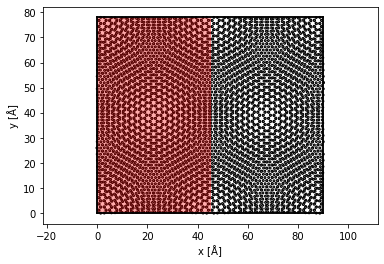

In [4]:
atoms = read('gra_3.15deg_bilayer_relaxed.cif')

atoms = orthogonalize_cell(atoms)

atoms *= (2,1,1)

atoms.center(axis=2, vacuum=5)

gridscan = GridScan((0,0),(atoms.cell[0,0] / 2, atoms.cell[1,1]), sampling=.2)

show_atoms(atoms, scans = gridscan);

We then create an IAM potential based on the parameterization by Lobato and van Dyck (abTEM default) with 1024 gridpoints.

In [5]:
potential = Potential(atoms, gpts=1024).build(pbar=True)

Potential:   0%|          | 0/27 [00:00<?, ?it/s]

# ADF

As an initial test, we can simulate an annular dark field image of the specimen (note that this was not included in the published article).

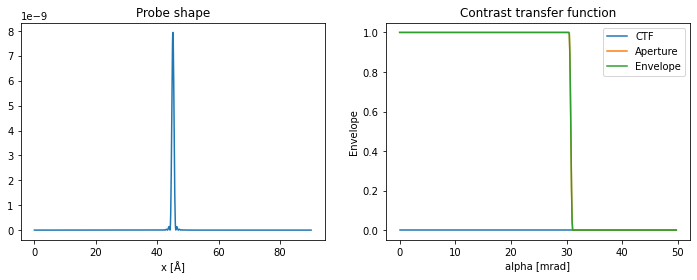

In [12]:
S = SMatrix(semiangle_cutoff=31, # mrad
            energy=60e3, # eV
            defocus=0, # Angstrom
            rolloff=0.02, # soften aperture 2 %
            interpolation=8,
            device=device,
            storage='cpu')

S.grid.match(potential)

gridscan.sampling = .9 * S.ctf.nyquist_sampling

equivalent_probe = S.equivalent_probe()

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
equivalent_probe.profile().show(ax=ax1);
ax1.set_title('Probe shape')
S.ctf.show(ax=ax2);
ax2.set_title('Contrast transfer function');

In [14]:
print('Scan sampling:', gridscan.sampling, 'Å')
print('Max scattering angle:', S.cutoff_scattering_angles, 'mrad')
print('Real space sampling:', S.sampling, 'Å')

Scan sampling: (0.351875, 0.3529935220493314) Å
Max scattering angle: (185.8264621185636, 184.63337844068508) mrad
Real space sampling: (0.08796875178813934, 0.07618317008018494) Å


In [8]:
detector = AnnularDetector(inner=50, outer=150)
measurement = S.scan(gridscan, detector, potential)

Multislice:   0%|          | 0/143 [00:00<?, ?it/s]

Scan:   0%|          | 0/28288 [00:00<?, ?it/s]

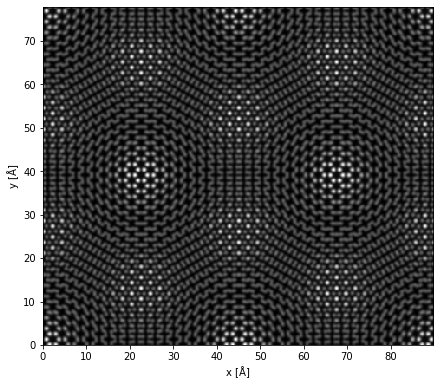

In [9]:
measurement.tile((2,1)).interpolate(.2).show(figsize=(7,7));

# 4D-STEM

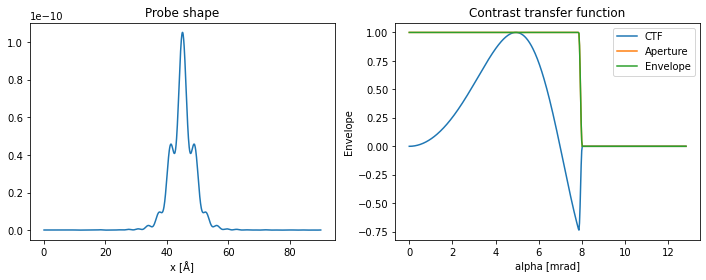

In [26]:
S = SMatrix(expansion_cutoff=8, # mrad
            semiangle_cutoff=8, # mrad
            energy=60e3, # eV
            defocus=1000, # Angstrom
            rolloff=0.02, # soften aperture 2 %
            interpolation=1, # no interpolation, we want good Fourier space sampling
            device=device,
            storage='cpu')

S.grid.match(potential)

gridscan.sampling = .9 * S.ctf.nyquist_sampling

equivalent_probe = S.equivalent_probe()

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
equivalent_probe.profile().show(ax=ax1);
ax1.set_title('Probe shape')
S.ctf.show(ax=ax2);
ax2.set_title('Contrast transfer function');

In [27]:
print('Scan sampling:', gridscan.sampling, 'Å')
print('Max scattering angle:', S.cutoff_scattering_angles, 'mrad')
print('Real space sampling:', S.sampling, 'Å')

Scan sampling: (1.3648484848484848, 1.3450270409121075) Å
Max scattering angle: (184.47597910898102, 184.63337844068508) mrad
Real space sampling: (0.08796875178813934, 0.07618317008018494) Å


In [18]:
S_array = S.multislice(potential, pbar=True)

Multislice:   0%|          | 0/27 [00:00<?, ?it/s]

After multislice is done, we can safely downsample in Fourier space to save disk space and memory.

In [19]:
S_array = S_array.downsample(max_angle=60) # mrad

In [20]:
detector = PixelatedDetector(save_file='grabi_4dstem_data.hdf5')
measurement = S_array.scan(gridscan, detector, max_batch_probes=500)

Scan:   0%|          | 0/1914 [00:00<?, ?it/s]

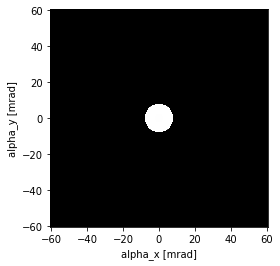

In [21]:
from abtem.measure import center_of_mass, bandlimit

measurement = Measurement.read('grabi_4dstem_data.hdf5')
measurement[0,0].show();

We can use the bandlimit function is 'highpass' mode to eliminate the central disk.

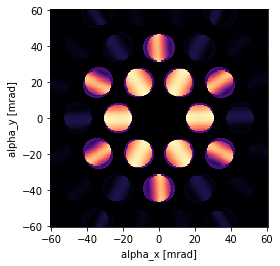

In [22]:
bandlimit(measurement,cutoff=10,band_type='highpass')[0,0].show(cmap='magma');

Before calculating the center of mass we use the `bandlimit` function in 'lowpass' mode to select the maximum integrated angle.

In [23]:
com = center_of_mass(bandlimit(measurement, cutoff=10, band_type='lowpass'), return_magnitude=True)

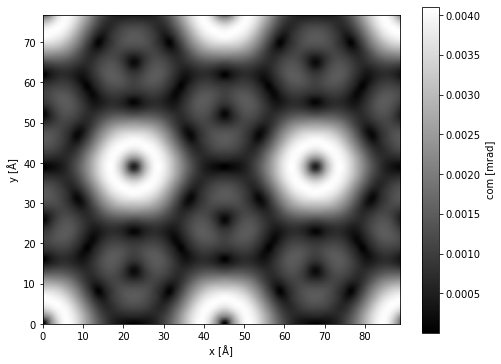

In [24]:
com.tile((2,1)).interpolate(.1).show(figsize=(8,6), cbar=True);